## Project: Finding Donors for Charity using Machine Learning

### Getting Started

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
### Exploring the Data
Let's add code to load necessary Python libraries and load the census data. 

Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [118]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display
import visuals as vs
import seaborn as sns
import matplotlib.pyplot as plt


DATASET = pd.read_csv("census.csv")
display(DATASET.head(n=10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. Let's compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [96]:
n_records = DATASET['income'].count()
n_greater_50k = len(DATASET[DATASET['income'] == '>50K'])
n_at_most_50k = len(DATASET[DATASET['income'] == '<=50K'])
greater_percent = (n_greater_50k / n_records) * 100

print("The total number of records: ({})".format(n_records))
print("Individuals making more than $50,000 : ({})".format(n_greater_50k))
print("Individuals making at most $50,000 : ({})".format(n_at_most_50k))
print("The percentage of individuals making more than $50,000 : ({:,.2f}%)".format(greater_percent))

The total number of records: (45222)
Individuals making more than $50,000 : (11208)
Individuals making at most $50,000 : (34014)
The percentage of individuals making more than $50,000 : (24.78%)


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [97]:
DATASET.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Let's plot a histogram of these two features.

C:\Users\Mustafa\Desktop\Project\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


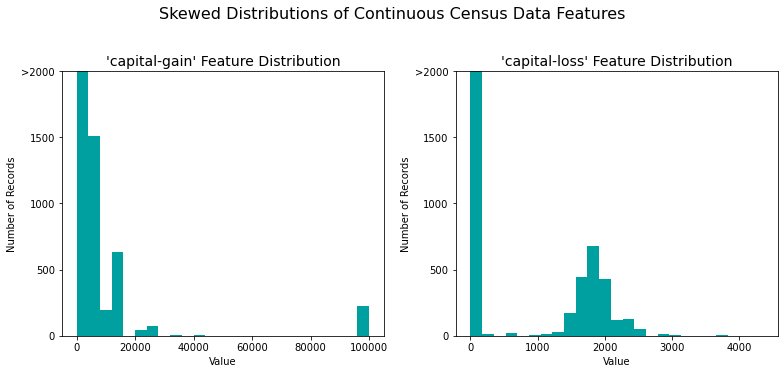

In [119]:
income_raw = DATASET['income']
features_raw = DATASET.drop('income', axis = 1)
vs.distribution(DATASET)

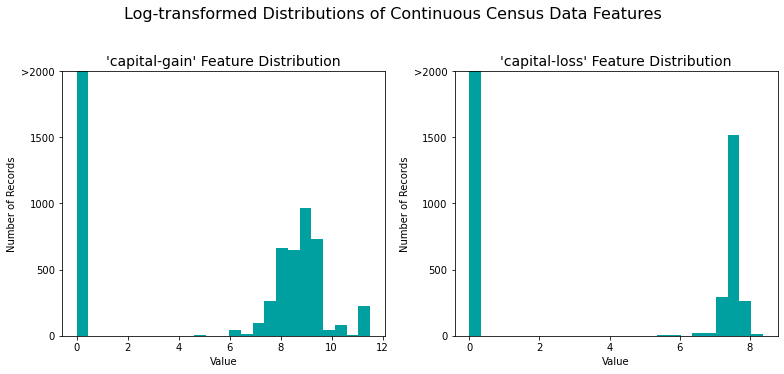

In [120]:
SKEWED = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[SKEWED] = features_raw[SKEWED].apply(lambda x: np.log(x + 1))
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Let's normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [121]:
from sklearn.preprocessing import MinMaxScaler
SCLR = MinMaxScaler()
NUMERIC = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[NUMERIC] = SCLR.fit_transform(features_log_transformed[NUMERIC])
display(features_log_minmax_transform.head(n = 10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba
5,0.273973,Private,Masters,0.866667,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0.0,0.397959,United-States
6,0.438356,Private,9th,0.266667,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.000000,0.0,0.153061,Jamaica
7,0.479452,Self-emp-not-inc,HS-grad,0.533333,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.448980,United-States
8,0.191781,Private,Masters,0.866667,Never-married,Prof-specialty,Not-in-family,White,Female,0.829751,0.0,0.500000,United-States
9,0.342466,Private,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.742849,0.0,0.397959,United-States


In [101]:
features_final = pd.get_dummies(features_log_minmax_transform)
income = np.where(income_raw.values == '>50K', 1, 0)
ENCODE = list(features_final.columns)
print("The total number of features after one-hot : ({})".format(len(ENCODE)))
print(ENCODE)

The total number of features after one-hot : (103)
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occup

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = 0.2, random_state = 0)
print("The number of training set include : ({}) samples.".format(X_train.shape[0]))
print("The number of testing set include : ({}) samples.".format(y_test.shape[0]))

The number of training set include : (36177) samples.
The number of testing set include : (9045) samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Naive Predictor Performace
What if we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

**Please note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

In [123]:
accuracy = n_greater_50k / n_records
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)
recall = n_greater_50k / (n_greater_50k + 0)
fscore =  (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
Let's use following supervised learning models that are currently available in [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) for this problem to test on the census data.

### 1. Logistic Regression

**Real world application:**

Logistic regression can be used to predict customer retention, such as a yes/no/maybe scenario indicating, whether a customer will re-visit/not visit again/may visit again based on the marketing stimuli.

**Strengths:**

1. It performs well when the dataset is linearly separable.
2. It is less prone to over-fitting but it can overfit in high dimensional datasets. 
3. Logistic regression is easier to implement, interpret and very efficient to train. 

**Weaknesses:**

1. Assumption of linearity between the dependent variable and the independent variables. In the real world, the data is rarely linearly separable.
2. If the number of observations are lesser than the number of features, Logistic Regression should not be used, otherwise it may lead to overfit.
3. It can only be used to predict discrete functions.

**Candidacy:**

As the prediction values are discrete (i.e. 0 or 1) in our problem, logistic regression is best suited to solve given problem


### 2. AdaBoost

**Real world application:**

AdaBoost is a powerful classification algorithm used in a wide variety of fields such as biology, computer vision, and speech processing.

**Strength:**

Adaboost is more robust than single estimators, have improved generalizability.
Simple models can be combined to build a complex model, which is computationally fast.

**Weaknesses:**

AdaBoost can be sensitive to noisy data and outliers
If we have a biased underlying classifier, it will lead to a biased boosted model.

**Candidacy:**

Adaboost is is considered to be high quality classifiers and the one of most popular boosting algorithms. We also have a class imbalance in our dataset, which boosting might be robust to.

### 3. Gradient Boosting

**Real world application:**

The commercial web search engines Yahoo and Yandex use variants of gradient boosting in their machine-learned ranking engines.

**Strengths:**

1. It produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise and it generalizes them with highly accurate results
2. Supports different loss function.
3. Works well with interactions.

**Weaknesses:**

1. Prone to over-fitting.
2. Requires careful tuning of different hyper-parameters

**Candidacy:**

Due to high accuracy in prediction and ensemble learning from weak prediction models, Gradient Boosting will surely help us to solve given problem i.e. predicting an individual who makes more than 50K.

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [124]:

from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation

C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.


C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments 

LogisticRegression trained on 36177 samples.


C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


AdaBoostClassifier trained on 361 samples.


C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


AdaBoostClassifier trained on 3617 samples.


C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0

AdaBoostClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.


C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


GradientBoostingClassifier trained on 3617 samples.


C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Mustafa\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


GradientBoostingClassifier trained on 36177 samples.


C:\Users\Mustafa\Desktop\Project\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


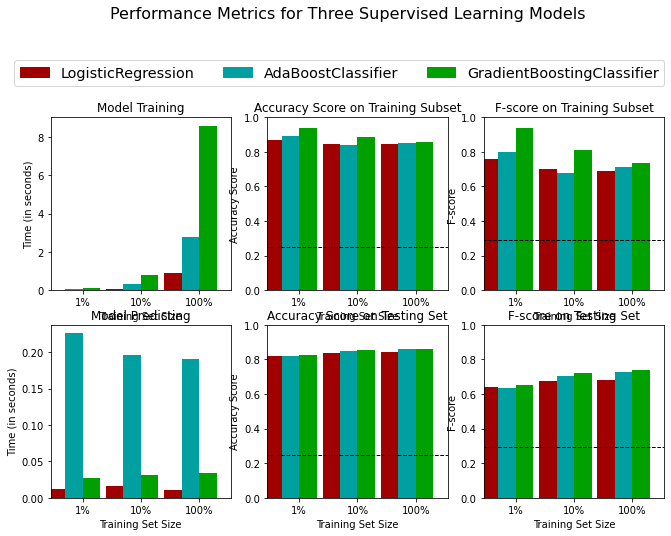

In [125]:
import visuals as vs
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf_A = LogisticRegression(random_state=44)
clf_B = AdaBoostClassifier(random_state=44)
clf_C = GradientBoostingClassifier(random_state=44)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results = {}

for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)
vs.evaluate(results, accuracy, fscore)

In [126]:
for i in results.items():
    print(i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

LogisticRegression


,1%,10%,100%
train_time,0.025927,0.058978,0.890697
pred_time,0.012000,0.015662,0.010970
acc_train,0.866667,0.846667,0.843333
acc_test,0.822554,0.838585,0.842123
f_train,0.757576,0.703125,0.690299
f_test,0.639046,0.677461,0.683685


AdaBoostClassifier


,1%,10%,100%
train_time,0.090757,0.314125,2.761461
pred_time,0.226393,0.196344,0.190280
acc_train,0.893333,0.840000,0.850000
acc_test,0.820674,0.849862,0.857601
f_train,0.801282,0.680147,0.711538
f_test,0.632757,0.701882,0.724551


GradientBoostingClassifier


,1%,10%,100%
train_time,0.100757,0.817154,8.589958
pred_time,0.026928,0.030912,0.033924
acc_train,0.940000,0.883333,0.856667
acc_test,0.827308,0.855943,0.863018
f_train,0.937500,0.813492,0.734127
f_test,0.649378,0.721604,0.739534


----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":20}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

### Choosing the Best Model

By looking at the above results, Gradient Boosting Classifier is the most appropriate for the task of identifying individuals that make more than \$50,000. This is concluded by considering below mentioned points

1. If we compare the F score of Gradient boosting (i.e. 0.769098) with other two models i.e. AdaBoost (0.751104) and Linear regression (0.701284), it shows that Gradient Boosting outperformed the other two models. Also the above confusion matrix clearly states that the Gradient Boosting has the highest prediction accuracy. 
2. Prediction time is considerably low as compare to other models whereas the training time is bit higher to the other model.
3. Finally, as compare to other models Gradient Boosting is the best suitable for identifying individuals that make more than \$50,000 as it outperformed the other model in Prediction score, F-score and Accuracy.

### Describing the Model in Layman's Terms

**Ensemble learning:**

In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. A machine learning ensemble consists of a finite set of alternative models, but typically allows for much more flexible structure to exist among those alternatives.

**Gradient boosting:**

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model stage-wise like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

### Model Tuning
Now, using grid search (`GridSearchCV`) with different parameters & respective values, we will train the entire training set.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initializing the classifier
clf = GradientBoostingClassifier(n_estimators=500, random_state=44)

# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = { 'max_depth' : [3, 5, 7], 'n_estimators' :[25, 50, 150],'min_samples_split' : [3, 4, 5] }
scorer = make_scorer(fbeta_score, beta=0.5)
grid_obj = GridSearchCV(clf, parameters, cv=2, scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

In [ ]:
best_clf = grid_fit.best_estimator_
print(best_clf)

### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8718      |     0.8718      |
| F-score        |       0.7545      |     0.7550      |


The Optimized model obtained the Accuracy Score of 0.8718 and F-Score of 0.7550.

The Optimized model's F-score is slightly better than the unpotimized model's F-score whereas Accuracy score is same for both the model.

As compared to the naive predictor benchmarks to new model we can say that, F-score increased from 0.2917 to 0.7550 and Accuracy increased from 0.2478 to 0.8718.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Feature Relevance Observation
When **Exploring the Data**, we have seen that there are thirteen available features for each individual on record in the census data. Of these thirteen records, let us find five features that are we assume to be most important for prediction. 

**Education:** People those who have completed higher education will have better chances of having better paid jobs 

**Age:** Older people with more experience are surely getting paid well as compare to younger ones with less experience. Also as people gets old there are more chances that they may have more accumulated money.

**Occupation:** People with high position are surely being paid well

**Capital-gain:** This is surely an added advantage for an individual as it directly leads to the income. 

**Hours-per-week:** People those who work more hours per week are surely earning more than others

### Extracting Feature Importance

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


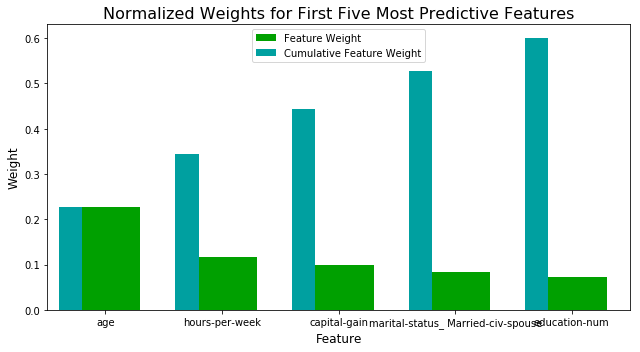

In [17]:
# Importing a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Training the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Extracting the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

As discussed earlier, Age, hours per week, capital gain and education-num (numeric value for education) are also considered by the Random Forest Classifier, as the most relevant features to predict an individual makes at most or above $50,000. Marital status which I have not considered to be the important feature seems that people those who are married and living together will have high cumulative income i.e. >50K

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [18]:
from sklearn.base import clone

X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

reduced_predictions = clf.predict(X_test_reduced)
print("Final Model trained on full data\n------")
print("Accuracy on testing data: ({:.4f})".format(accuracy_score(y_test, best_predictions)))
print("F-score on the testing data: ({:.4f})".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on the testing data: ({:.4f})".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on the testing data: ({:.4f})".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8703
F-score on testing data: 0.7507

Final Model trained on reduced data
------
Accuracy on testing data: 0.8496
F-score on testing data: 0.7017


### Effects of Feature Selection
The final model's F-score and accuracy score on the reduced data is still more useful and suitable for prediction as compare to the model with all features. If the training time factor is more important for any use case, it is more worth to consider reduced data as training set instead of using all features.